# Analysis of extractive structures results

### Imports

In [1]:
%load_ext autoreload
%load_ext line_profiler
%load_ext snakeviz
%autoreload 2
import unicodedata
# Add the top level of the directory to the python path, so we can import the scripts
import sys
from pathlib import Path
import os
from shared_ml.utils import get_root_of_git_repo
from transformers import AutoTokenizer
import torch
from transformers.generation.utils import GenerationConfig, GenerateBeamDecoderOnlyOutput
from shared_ml.utils import default_function_args_to_cache_id, hash_str
from transformers import PreTrainedModel, PreTrainedTokenizer, PreTrainedTokenizerFast
from typing import Any
from termcolor import colored
repo_root = get_root_of_git_repo()



import matplotlib.pyplot as plt
from typing import Any, cast
import seaborn as sns
import json
from oocr_influence.cli.train_extractive import TrainingArgs
from oocr_influence.cli.run_influence import InfluenceArgs
from oocr_influence.cli.train_extractive import TrainingArgs
from oocr_influence.cli.run_influence import InfluenceArgs
from dataclasses import dataclass
from datasets import DatasetDict
from shared_ml.logging import LogState, load_log_from_wandb, paths_or_wandb_to_logs
import re
from collections import defaultdict
from typing import TypeVar
from numpy.typing import NDArray
from shared_ml.utils import cache_function_outputs
from itertools import chain, groupby
import numpy.typing as npt

import numpy as np
import matplotlib.pyplot as plt
if repo_root not in sys.path:\
    sys.path.append(repo_root)
# Also chang the CWD to the repo, so we can import items from the various scripts.
os.chdir(repo_root)
from shared_ml.logging import load_experiment_checkpoint

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

import logging
from typing import Literal
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, Conv1D
from torch import nn
from kronfluence.analyzer import Analyzer, prepare_model
from datasets import Dataset
from kronfluence.arguments import FactorArguments, ScoreArguments
from kronfluence.task import Task
from kronfluence.utils.common.factor_arguments import all_low_precision_factor_arguments
from kronfluence.utils.common.score_arguments import all_low_precision_score_arguments
from kronfluence.utils.dataset import DataLoaderKwargs
import numpy as np
from kronfluence.score import load_pairwise_scores
from oocr_influence.cli.run_influence import InfluenceArgs
# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

## Influence analysis

In [51]:
from collections import defaultdict
from typing import Any, Literal
import line_profiler
import time
import numpy as np
from numpy.typing import NDArray
import torch
from datetime import datetime
from datasets import Dataset
from pathlib import Path
import hashlib
from functools import cache
from typing import Generator

from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast
from shared_ml.utils import cache_function_outputs
from shared_ml.data import hash_str
from oocr_influence.analysis_utils import split_dataset_and_scores_by_document
import re
import matplotlib.pyplot as plt
from line_profiler import profile
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import seaborn as sns
from termcolor import colored
import pandas as pd
from itertools import chain
import math
from oocr_influence.analysis_utils import split_dataset_and_scores_by_document, reduce_scores, load_influence_scores

import hashlib
from collections import defaultdict
from typing import Any, List, Tuple

import numpy as np
from datasets import Dataset
from numpy.typing import NDArray
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast
import safetensors
import hashlib, numpy as np
from collections import defaultdict
from typing import Any, List, Tuple
from datasets import Dataset
from numpy.typing import NDArray
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast
import json
from oocr_influence.cli.train_extractive import TrainingArgs
import time
import wandb
from pydantic import BaseModel
from shared_ml.logging import LogState, load_log_from_disk
import cProfile
from transformers import PreTrainedTokenizerFast
import pstats
import io
from pathlib import Path
import line_profiler 
import matplotlib.style as mplstyle

import hashlib, numpy as np, itertools
from collections import defaultdict
from typing import Any, List, Tuple
from datasets import Dataset, Features, Value, Sequence
from numpy.typing import NDArray
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast 


@cache_function_outputs(cache_dir=Path("./analysis/cache_dir/"), function_args_to_cache_id = lambda x: hashlib.sha256(x["input_array"].tobytes()).hexdigest()[:8]) # type: ignore
def rank_influence_scores(input_array: np.ndarray[Any, Any] | torch.Tensor) -> np.ndarray[Any, Any]:
    if isinstance(input_array, torch.Tensor):
        input_array = input_array.cpu().numpy()
    return np.argsort(np.argsort(-input_array, axis=1), axis=1)

def get_parent_influence_scores(influence_scores: np.ndarray[Any,np.dtype[Any]] | torch.Tensor, test_dataset: Dataset) -> np.ndarray[Any,np.dtype[Any]]:
    if isinstance(influence_scores, torch.Tensor):
        influence_scores = influence_scores.cpu().numpy()
    parent_idxs: list[int] = test_dataset["parent_fact_idx"]
    influence_scores_by_parent = influence_scores[np.arange(len(influence_scores)), parent_idxs]
    return influence_scores_by_parent


def get_parent_influence_ranks(influence_scores: NDArray[Any] | torch.Tensor, train_dataset: Dataset, test_dataset: Dataset, non_parents_instead_of_parents : bool = True) -> dict[int,NDArray[Any]]:
    
    influence_scores_rank = rank_influence_scores(influence_scores)

    types = train_dataset["type"]
    idxs = [fact["idx"] if fact is not None else None for fact in train_dataset["fact"]]
    train_set_parent_idxs = [idx if "fact" in t else None for t,idx in zip(types,idxs)]
    
    parent_idxs_to_train_set_idxs = defaultdict(list)

    for train_set_idx, train_set_parent_idx in enumerate(train_set_parent_idxs):
        if train_set_parent_idx is not None:
            parent_idxs_to_train_set_idxs[train_set_parent_idx].append(train_set_idx)
        
    if non_parents_instead_of_parents:
        # Make it so that you are in the list if you are NOT a parent
        fact_indices = set(idx for idx, type in enumerate(train_dataset["type"]) if "fact" in type)
        parent_idxs_to_train_set_idxs = {k: list(fact_indices - set(v)) for k, v in parent_idxs_to_train_set_idxs.items()}
    parent_idxs_to_influence_ranks = {parent_idx: influence_scores_rank[parent_idx,train_set_idxs] for parent_idx,train_set_idxs in parent_idxs_to_train_set_idxs.items()}

    return parent_idxs_to_influence_ranks  

def plot_histogram_train_subset(influence_scores: NDArray[Any] | torch.Tensor, train_dataset: Dataset, subset_inds: list[int], title: str, xlabel: str, ylabel: str,bin_width: int = 10,max_value: int | None = None, fig: Figure | None = None, ax: Axes | None = None, test_inds_to_focus_on: list[int] | None = None, analysis_dir: Path | None = None):
    if isinstance(influence_scores, torch.Tensor):
        influence_scores = influence_scores.to(dtype=torch.float32).cpu().numpy()

    influence_ranks = rank_influence_scores(influence_scores)
    max_value = max_value or np.max(influence_ranks)
    subset_influence_ranks = influence_ranks[:,subset_inds]
    if test_inds_to_focus_on is not None:
        subset_influence_ranks = subset_influence_ranks[test_inds_to_focus_on]
    if fig is None:
        fig, ax = plt.subplots()
    else:
        ax = fig.gca()
    
    ax.hist(subset_influence_ranks.flatten(), edgecolor="black", bins=np.arange(0, max_value + 1, bin_width)) # type: ignore
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # show the figure
    fig.show()
    if analysis_dir is not None:
        save_location = analysis_dir / f"{title}_{plot_histogram_train_subset.__name__}.pdf".replace("\n", "_")
        fig.savefig(save_location, format="pdf")
    return fig, ax


def get_mlp_and_attention_groups(module_names: list[str]) -> tuple[list[list[str]], list[list[str]]]:
    
    layer_match = re.compile(r"\.(\d+)\.")
    layers = [int(layer_match.search(module_name).group(1)) for module_name in module_names ]
    layer_mlp_groups : list[list[str]] = [[] for _ in range(max(layers)+ 1)]
    layer_attention_groups : list[list[str]] = [[] for _ in range(max(layers)+ 1)]
    
    for module_name, layer in zip(module_names, layers):
        if "mlp" in module_name:
            layer_mlp_groups[layer].append(module_name)
        elif "attn" in module_name:
            layer_attention_groups[layer].append(module_name)

    return layer_mlp_groups, layer_attention_groups
def plot_heatmap_influence_scores_by_layer(influence_scores_by_layer: dict[str, np.ndarray] | dict[str, torch.Tensor], train_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str, aggregation_type: Literal["sum", "abs_sum","ranks_above_median","ranks_below_median"] = "sum"):
    if isinstance(next(iter(influence_scores_by_layer.values())), torch.Tensor):
        influence_scores_by_layer = {k: v.to(dtype=torch.float32).cpu().numpy() for k, v in influence_scores_by_layer.items()} # type: ignore
    parent_idxs = test_dataset["parent_fact_idx"]
    
    groups_mlp, groups_attention = get_mlp_and_attention_groups(list(influence_scores_by_layer.keys()))
     
    title = f"{title} ({aggregation_type})"
        
    
    if aggregation_type == "sum" or aggregation_type == "abs_sum":
        groups_to_influence = {}
        for group_name, group in zip(["attention", "mlp"], [groups_attention, groups_mlp]):
            layer_group_to_influence = defaultdict(float)
            for layer_num, layer_group in enumerate(group):
                layer_group_influence = 0
                for layer_name in layer_group:
                    influence_score = influence_scores_by_layer[layer_name]
                    influence_score_by_parent = influence_score[np.arange(len(influence_score)), parent_idxs]
                    if aggregation_type == "abs_sum":
                        influence_score_by_parent = np.abs(influence_score_by_parent)
                    
                    layer_group_influence += np.sum(influence_score_by_parent)
                
                layer_group_to_influence[f"{group_name}_{layer_num}"] = layer_group_influence
            
            groups_to_influence[group_name] = layer_group_to_influence
    elif aggregation_type == "ranks_below_median" or aggregation_type == "ranks_above_median":
        groups_to_influence = {}
        for group_name, group in zip(["attention", "mlp"], [groups_attention, groups_mlp]):
            layer_group_to_influence_array = defaultdict(lambda: np.zeros(len(parent_idxs)))
            for layer_num, layer_group in enumerate(group):
                layer_group_influence_parents  = np.zeros(len(parent_idxs))
                for layer_name in layer_group:
                    influence_score = influence_scores_by_layer[layer_name]
                    influence_score_by_parent = influence_score[np.arange(len(influence_score)), parent_idxs]
                    if aggregation_type == "ranks_below_median":
                        influence_score_by_parent = -influence_score_by_parent
                    layer_group_influence_parents += influence_score_by_parent
                
                layer_group_to_influence_array[f"{group_name}_{layer_num}"] = layer_group_influence_parents
                
                
            layer_group_influence_stacked = np.stack(list(layer_group_to_influence_array.values()), axis=0)
            
            # now, rank the influence scores for each parent, and then subtract the median rank, clipping at 0 from all the ranks
            layer_group_influence_stacked_ranks = np.argsort(np.argsort(-layer_group_influence_stacked, axis=0), axis=0)
            layer_group_influence_stacked_ranks_above_median = np.clip(layer_group_influence_stacked_ranks - np.median(layer_group_influence_stacked_ranks, axis=0, keepdims=True), 0, None)
            layer_group_influence = np.sum(layer_group_influence_stacked_ranks_above_median, axis=1)
            layer_group_to_influence = {}
            for layer_name, influence in zip(list(layer_group_to_influence_array.keys()), layer_group_influence):
                layer_group_to_influence[layer_name] = influence
            
            groups_to_influence[group_name] = layer_group_to_influence
    else:
        raise ValueError(f"Aggregation type {aggregation_type} not recognised")

    # Create a single figure with side-by-side subfigures for attention and mlp
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    
    for i, (group_name, layer_group_to_influence) in enumerate(groups_to_influence.items()):
        ax = axes[i]
        influences_array = np.array(list(layer_group_to_influence.values())).reshape(-1, 1)
        # add yticks for each layer name
        ax.set_yticks(np.arange(len(layer_group_to_influence)))
        sns.heatmap(influences_array[:,::-1], cmap="viridis", ax=ax, yticklabels=list(layer_group_to_influence.keys())[::-1])
        ax.set_title(f"{title} - {group_name.capitalize()}")
        ax.set_xlabel(xlabel)
        if i == 0:  # Only add y-label to the first subplot
            ax.set_ylabel(ylabel)
    
    fig.show()

    return fig, axes
    
# TODO: Some trickyness about normalising scores by layer
def plot_magnitude_across_queries(influence_scores: np.ndarray[Any, Any] | torch.Tensor, train_dataset: Dataset, test_dataset: Dataset, title: str, xlabel: str, ylabel: str, is_per_token: bool):
    
    magnitudes = np.sum(np.abs(influence_scores), axis=1)
    fig, ax = plt.subplots()
    sns.barplot(x=np.arange(len(magnitudes)), y=magnitudes, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    return fig, ax




import pandas as pd
from datasets import Dataset
from typing import Any, Dict
import json

TYPES = ["pretraining_document", "parent_fact", "non_parent_fact", "few_shot_example", "distractor_fact", "distractor_fact_for_other_person"]

def get_datapoint_type(query_datapoint: dict[str, Any], train_datapoint: dict[str, Any]) -> str:
    """
    Determine the type of relationship between a query and training datapoint.
    """
    query_datapoint_idx = query_datapoint["fact"]["id"]
    few_shot_city_idxs = [ex["id"] for ex in query_datapoint["few_shot_examples"]]
    train_type = train_datapoint["type"]
    train_idx = None if train_datapoint["fact"] is None else train_datapoint["fact"]["id"]
    query_features = json.loads(query_datapoint["fact"]["fields_json"])
    train_features = json.loads(train_datapoint["fact"]["fields_json"]) if train_datapoint["fact"] is not None else None
    
    if train_type == "pretraining_document":
        type_to_return = "pretraining_document"
    elif train_type == "atomic_fact" and train_idx == query_datapoint_idx:
        type_to_return = "parent_fact"
    elif train_type == "atomic_fact" and train_idx in few_shot_city_idxs:
        type_to_return = "few_shot_example"
    elif train_type == "atomic_fact" and train_idx != query_datapoint_idx:
        type_to_return = "non_parent_fact"
    elif train_type == "distractor_fact" and train_features["name_of_person"] == query_features["name_of_person"]:
        type_to_return = "distractor_fact"
    elif train_type == "distractor_fact" and train_features["name_of_person"] != query_features["name_of_person"]:
        type_to_return = "distractor_fact_for_other_person"
    else:
        type_to_return = "non_parent_fact"
    
    return type_to_return

from tqdm import tqdm
def add_types_to_influence_scores(
    influence_scores_df: pd.DataFrame,
    test_dataset: Dataset,
    train_dataset: Dataset
) -> pd.DataFrame:
    """
    Add a 'datapoint_type' column to the influence scores dataframe.
    
    Args:
        influence_scores_df: DataFrame with columns ['query_id', 'train_id', 'influence_score', 'per_token_influence_score']
        test_dataset: Dataset containing query datapoints (with 'id' field)
        train_dataset: Dataset containing training datapoints (with 'id' field)
    
    Returns:
        DataFrame with an additional 'datapoint_type' column
    """
    # Create a copy to avoid modifying the original
    result_df = influence_scores_df.copy()
    
    # Create ID to index mappings for efficient lookup
    test_id_to_idx = {id: idx for idx, id in enumerate(test_dataset["id"])}
    train_id_to_idx = {id: idx for idx, id in enumerate(train_dataset["id"])}
    
    # Initialize list to store types
    datapoint_types = []

    train_dataset_df = train_dataset.to_pandas()
    test_dataset_df = test_dataset.to_pandas()
    
    # Process each row in the dataframe
    for _, row in tqdm(influence_scores_df.iterrows()):
        query_id = row['query_id']
        train_id = row['train_id']
        
        # Look up indices from IDs
        if query_id not in test_id_to_idx:
            raise ValueError(f"query_id '{query_id}' not found in test_dataset")
        if train_id not in train_id_to_idx:
            raise ValueError(f"train_id '{train_id}' not found in train_dataset")
        
        query_idx = test_id_to_idx[query_id]
        train_idx = train_id_to_idx[train_id]
        
        # Get the datapoints
        query_datapoint = test_dataset_df.iloc[query_idx].to_dict()
        train_datapoint = train_dataset_df.iloc[train_idx].to_dict()
        
        # Determine the type
        datapoint_type = get_datapoint_type(query_datapoint, train_datapoint)
        datapoint_types.append(datapoint_type)
    
    # Add the types column to the dataframe
    result_df['datapoint_type'] = datapoint_types
    
    return result_df




from datasets import concatenate_datasets
from oocr_influence.cli.train_extractive import TrainingArgs
from typing import TypeVar
from pydantic import BaseModel
from dataclasses import dataclass
from pathlib import Path
import wandb
T = TypeVar("T", bound=BaseModel)
def run_id_to_training_args(run_id: str | Path,entity: str = "max-kaufmann", project: str = "malign-influence",args_clss : type[T] = TrainingArgs) -> tuple[T, Path]:

    api = wandb.Api()
    run = api.run(f"{entity}/{project}/{run_id}")
    args = run.config
    output_dir = Path(run.summary["experiment_output_dir"])

    args = {k:v for k,v in args.items() if k in args_clss._schema()["properties"]}
    return args_clss.model_validate(args), output_dir

import pandas as pd
import numpy as np
from typing import Dict, List, Optional
from transformers import PreTrainedTokenizerFast
from datasets import Dataset
from pathlib import Path

def output_top_influence_documents_html(
    tokenizer: PreTrainedTokenizerFast,
    scores_df: pd.DataFrame,
    train_dataset: Dataset,
    query_dataset: Dataset,
    prob_vector: np.ndarray | None = None,
    *,
    n_queries: int = 2,
    n_train: int = 20,
    query_ids_to_focus_on: List[str] | None = None,
) -> dict[str, str]:
    """
    Build one HTML document per query with colored boxes and scores.
    Returns a dictionary mapping query names to HTML strings.
    
    Args:
        tokenizer: Tokenizer for decoding tokens
        scores_df: DataFrame with columns [query_id, train_id, influence_score, per_token_influence_score, datapoint_type]
        train_dataset: Dataset containing training examples
        query_dataset: Dataset containing query examples
        prob_vector: Optional probability vector for queries
        n_queries: Number of queries to process
        n_train: Number of top training documents to show per query
        query_ids_to_focus_on: Optional list of specific query IDs to process
    """
    
    def escape_html(text: str) -> str:
        """Escape HTML special characters."""
        return (text.replace("&", "&amp;")
                    .replace("<", "&lt;")
                    .replace(">", "&gt;")
                    .replace('"', "&quot;")
                    .replace("'", "&#39;"))
    
    def get_color_rgb(score: float, std_devs: float) -> tuple[str, str]:
        """Get RGB color string based on standard deviations from mean.
        Returns (background_color, text_color) tuple."""
        
        # Clamp to reasonable range
        std_devs_clamped = max(-3, min(3, std_devs))
        
        # Map std devs to intensity (0 to 1)
        intensity = abs(std_devs_clamped) / 3.0
        
        # Use lighter colors - start from white and add color
        # For positive scores (green tint)
        if score >= 0:
            # Light green: decrease red and blue channels
            r = int(255 - (100 * intensity))  # Reduced from 255 to add green tint
            g = 255  # Keep green at max
            b = int(255 - (100 * intensity))  # Reduced from 255 to add green tint
            bg_color = f"rgb({r}, {g}, {b})"
        else:
            # Light red: decrease green and blue channels
            r = 255  # Keep red at max
            g = int(255 - (100 * intensity))  # Reduced from 255 to add red tint
            b = int(255 - (100 * intensity))  # Reduced from 255 to add red tint
            bg_color = f"rgb({r}, {g}, {b})"
        
        # Text is always dark for readability
        text_color = "#333"
        
        return bg_color, text_color
    
    def check_shared_entity(query_item, train_item) -> bool:
        """Check if query and training item share the same parent entity."""
        # Extract entity information from both items
        # This assumes the entity is stored in the fact structure
        # Adjust the field names based on your actual data structure
        
        query_entity = None
        train_entity = None
        
        # Try different possible entity field names
        if "fact" in query_item and query_item["fact"] is not None:
            query_entity = json.loads(query_item["fact"]["fields_json"])["name_of_person"]

        if "fact" in train_item and train_item["fact"] is not None:
            train_entity = json.loads(train_item["fact"]["fields_json"])["name_of_person"]
        
        # Return True if both entities exist and are the same
        return (query_entity is not None and 
                train_entity is not None and 
                query_entity == train_entity)
    
    # Create lookup dictionaries to map IDs to dataset indices
    # Assuming datasets have an 'id' field that matches the IDs in scores_df
    query_id_to_idx = {}
    for idx, item in enumerate(query_dataset):
        if 'id' in item:
            query_id_to_idx[str(item['id'])] = idx
        else:
            # Fallback: if no 'id' field, use index as string
            query_id_to_idx[str(idx)] = idx
    
    train_id_to_idx = {}
    for idx, item in enumerate(train_dataset):
        if 'id' in item:
            train_id_to_idx[str(item['id'])] = idx
        else:
            # Fallback: if no 'id' field, use index as string
            train_id_to_idx[str(idx)] = idx
    
    # Base CSS styles (updated to include shared entity styling)
    base_css = """
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 20px;
            background-color: #f9f9f9;
            color: #333;
        }
        .container {
            background-color: white;
            padding: 20px;
            border-radius: 8px;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        }
        .header {
            background-color: #f5f5f5;
            padding: 15px;
            border-radius: 5px;
            margin-bottom: 20px;
            font-size: 14px;
            border: 1px solid #e0e0e0;
        }
        .summary-table {
            border-collapse: collapse;
            width: 100%;
            margin-bottom: 30px;
        }
        .summary-table th {
            background-color: #f0f0f0;
            padding: 8px;
            text-align: left;
            border: 1px solid #ddd;
            font-weight: bold;
        }
        .summary-table td {
            padding: 6px;
            border: 1px solid #ddd;
        }
        .token-section {
            margin-top: 30px;
        }
        .token-header {
            font-weight: bold;
            font-size: 16px;
            margin-bottom: 10px;
        }
        .doc-header {
            margin: 15px 0 10px 0;
            font-weight: bold;
            color: #333;
            background-color: #f8f8f8;
            padding: 8px;
            border-radius: 4px;
            display: flex;
            justify-content: space-between;
            align-items: center;
        }
        .doc-type {
            background-color: #e3f2fd;
            color: #1976d2;
            padding: 3px 8px;
            border-radius: 3px;
            font-size: 12px;
            font-weight: normal;
        }
        .toggle-button {
            background-color: #2196F3;
            color: white;
            border: none;
            padding: 4px 12px;
            border-radius: 4px;
            cursor: pointer;
            font-size: 12px;
            transition: background-color 0.3s;
        }
        .toggle-button:hover {
            background-color: #1976D2;
        }
        .score-label {
            display: block;
            font-size: 11px;
            margin-top: 2px;
            color: #555;
            text-align: center;
        }
        .token-with-score {
            display: inline-block;
            vertical-align: top;
            margin: 2px;
        }
        .token-display {
            line-height: 2.2;
            margin-bottom: 10px;
            font-family: 'Courier New', monospace;
        }
        .token-display.detailed-view {
            line-height: 1.5;
        }
        .token-cell {
            display: inline-block;
            padding: 4px 6px;
            margin: 2px;
            border-radius: 4px;
            text-align: center;
            min-width: 20px;
            border: 1px solid rgba(0,0,0,0.1);
            position: relative;
            font-size: 14px;
            vertical-align: top;
        }
        .std-dev-indicator {
            position: absolute;
            top: -8px;
            right: -8px;
            font-size: 10px;
            background-color: rgba(0,0,0,0.7);
            color: white;
            padding: 1px 4px;
            border-radius: 10px;
            font-weight: bold;
        }
        .score-display {
            font-size: 12px;
            color: #666;
            margin-top: 5px;
            margin-bottom: 20px;
        }
        .positive-score {
            color: #2e7d32;
            font-weight: bold;
        }
        .negative-score {
            color: #c62828;
            font-weight: bold;
        }
        .parent-tag {
            background-color: #4CAF50;
            color: white;
            padding: 2px 6px;
            border-radius: 3px;
            font-size: 12px;
        }
        .not-parent-tag {
            background-color: #9e9e9e;
            color: white;
            padding: 2px 6px;
            border-radius: 3px;
            font-size: 12px;
        }
        .shared-entity-tag {
            background-color: #FF9800;
            color: white;
            padding: 2px 6px;
            border-radius: 3px;
            font-size: 12px;
        }
        .no-shared-entity-tag {
            background-color: #757575;
            color: white;
            padding: 2px 6px;
            border-radius: 3px;
            font-size: 12px;
        }
        .stats-info {
            font-size: 12px;
            color: #666;
            margin-bottom: 8px;
            font-style: italic;
        }
        /* Hide score labels by default */
        .token-display .score-label {
            display: none;
        }
        /* Show score labels when in detailed view */
        .token-display.detailed-view .score-label {
            display: block;
        }
        /* Hide std-dev indicators in detailed view */
        .token-display.detailed-view .std-dev-indicator {
            display: none;
        }
    </style>
    <script>
        function toggleScoreView(docId) {
            const container = document.getElementById('tokens-' + docId);
            const button = document.getElementById('toggle-' + docId);
            const isDetailed = container.classList.toggle('detailed-view');
            button.textContent = isDetailed ? 'Hide All Scores' : 'Show All Scores';
        }
    </script>
    """
    
    # Get unique query IDs to process
    all_query_ids = scores_df['query_id'].unique()
    
    if query_ids_to_focus_on is not None:
        query_ids = [qid for qid in query_ids_to_focus_on if qid in all_query_ids][:n_queries]
    else:
        # Sort query IDs based on their corresponding indices if possible
        try:
            sorted_query_ids = sorted([qid for qid in all_query_ids if str(qid) in query_id_to_idx], 
                                    key=lambda x: query_id_to_idx[str(x)])
        except:
            sorted_query_ids = sorted(all_query_ids)
        query_ids = sorted_query_ids[:n_queries]
    
    html_docs: dict[str, str] = {}
    
    for query_id in query_ids:
        html_parts = []
        html_parts.append("<!DOCTYPE html>")
        html_parts.append("<html><head>")
        html_parts.append(f"<title>Query {query_id} Influence Analysis</title>")
        html_parts.append(base_css)
        html_parts.append("</head><body>")
        html_parts.append('<div class="container">')
        
        # Get query index from lookup dictionary
        q_idx = query_id_to_idx.get(str(query_id))
        if q_idx is None:
            continue
            
        # Header
        q_item = query_dataset[q_idx]
        header_text = f"Query {query_id}: PROMPT: {q_item['prompt']} | COMPLETION: {q_item['completion']}"
        if prob_vector is not None and q_idx < len(prob_vector):
            header_text += f" | P(correct)={prob_vector[q_idx]:.3f}"
        
        html_parts.append(f'<div class="header">{escape_html(header_text)}</div>')
        
        # Get all influence scores for this query, sorted by score (descending)
        query_df = scores_df[scores_df['query_id'] == query_id]
        query_df_sorted = query_df.nlargest(n_train, 'influence_score')
        
        # Summary table (updated with shared entity column)
        html_parts.append('<table class="summary-table">')
        html_parts.append('<thead><tr>')
        html_parts.append('<th>Rank</th><th>IF-Score</th><th>Type</th><th>Parent?</th><th>Shared Entity?</th><th>Preview</th>')
        html_parts.append('</tr></thead><tbody>')
        
        for rank, (_, row) in enumerate(query_df_sorted.iterrows()):
            train_id = row['train_id']
            t_idx = train_id_to_idx.get(str(train_id))
            if t_idx is None:
                continue
                
            if t_idx >= len(train_dataset):
                continue
                
            t_item = train_dataset[t_idx]
            
            # Check if this is the parent fact
            is_parent = (
                t_item["type"] == "atomic_fact"
                and t_item["fact"]["id"] == q_item["fact"]["id"]
            )
            
            # Check if they share the same entity
            has_shared_entity = check_shared_entity(q_item, t_item)
            
            if_score = row['influence_score']
            datapoint_type = row.get('datapoint_type', t_item['type'])
            
            score_class = "positive-score" if if_score >= 0 else "negative-score"
            parent_html = '<span class="parent-tag">PARENT</span>' if is_parent else '<span class="not-parent-tag">NOT-PARENT</span>'
            entity_html = '<span class="shared-entity-tag">SHARED</span>' if has_shared_entity else '<span class="no-shared-entity-tag">DIFFERENT</span>'
            
            preview = (t_item.get("prompt") or "")[:35].replace("\n", " ")
            
            html_parts.append('<tr>')
            html_parts.append(f'<td>{rank}</td>')
            html_parts.append(f'<td class="{score_class}">{if_score:+.3f}</td>')
            html_parts.append(f'<td>{escape_html(datapoint_type)}</td>')
            html_parts.append(f'<td>{parent_html}</td>')
            html_parts.append(f'<td>{entity_html}</td>')
            html_parts.append(f'<td>{escape_html(preview)}</td>')
            html_parts.append('</tr>')
        
        html_parts.append('</tbody></table>')
        
        # Per-token influence scores
        html_parts.append('<div class="token-section">')
        html_parts.append('<div class="token-header">Per-token IF scores:</div>')
        
        for rank, (_, row) in enumerate(query_df_sorted.iterrows()):
            train_id = row['train_id']
            t_idx = train_id_to_idx[str(train_id)]
                
            t_item = train_dataset[t_idx]
            input_ids = t_item["input_ids"]
            
            tok_scores = row['per_token_influence_score']
            tok_strings = tokenizer.batch_decode(input_ids)
            
            # Calculate mean and std dev for this document's influence scores
            scores_array = np.array(tok_scores)
            mean_score = np.mean(scores_array)
            std_score = np.std(scores_array)
            if std_score < 1e-7:  # Avoid division by zero
                std_score = 1e-7
            
            # Create unique ID for this document's token display
            doc_display_id = f"doc_{query_id}_{train_id}"
            
            # Header with type and toggle button
            html_parts.append('<div class="doc-header">')
            html_parts.append(f'<div>')
            html_parts.append(f'<span>--- Train doc #{train_id} (rank {rank}) ---</span>')
            html_parts.append(f' <span class="doc-type">{escape_html(row.get("datapoint_type", t_item["type"]))}</span>')
            html_parts.append(f'</div>')
            html_parts.append(f'<button id="toggle-{doc_display_id}" class="toggle-button" onclick="toggleScoreView(\'{doc_display_id}\')">Show All Scores</button>')
            html_parts.append('</div>')
            
            html_parts.append(f'<div class="stats-info">Mean: {mean_score:+.4f}, Std Dev: {std_score:.4f}</div>')
            
            # Token display with colors
            html_parts.append(f'<div id="tokens-{doc_display_id}" class="token-display">')
            
            for tok, sc in zip(tok_strings, tok_scores):
                score_float = float(sc)
                std_devs = (score_float - mean_score) / std_score
                
                # Handle newlines in tokens
                if "\n" in tok:
                    tok_parts = tok.split("\n")
                    for i, part in enumerate(tok_parts):
                        if i > 0:
                            html_parts.append("<br>")
                        if part:  # Only add non-empty parts
                            bg_color, text_color = get_color_rgb(score_float, std_devs)
                            
                            html_parts.append('<span class="token-with-score">')
                            html_parts.append(
                                f'<span class="token-cell" style="background-color: {bg_color}; color: {text_color};" '
                                f'title="Score: {score_float:+.4f} ({std_devs:+.2f}σ)">'
                                f'{escape_html(part)}'
                            )
                            
                            # Add std dev indicator for significant deviations (only shown in default view)
                            if abs(std_devs) >= 2.0:
                                html_parts.append(f'<span class="std-dev-indicator">{std_devs:+.0f}σ</span>')
                            
                            html_parts.append('</span>')
                            
                            # Add score label (only shown in detailed view)
                            html_parts.append(f'<span class="score-label">{score_float:+.3f}<br>{std_devs:+.1f}σ</span>')
                            html_parts.append('</span>')
                else:
                    bg_color, text_color = get_color_rgb(score_float, std_devs)
                    
                    html_parts.append('<span class="token-with-score">')
                    html_parts.append(
                        f'<span class="token-cell" style="background-color: {bg_color}; color: {text_color};" '
                        f'title="Score: {score_float:+.4f} ({std_devs:+.2f}σ)">'
                        f'{escape_html(tok)}'
                    )
                    
                    # Add std dev indicator for significant deviations (only shown in default view)
                    if abs(std_devs) >= 2.0:
                        html_parts.append(f'<span class="std-dev-indicator">{std_devs:+.0f}σ</span>')
                    
                    html_parts.append('</span>')
                    
                    # Add score label (only shown in detailed view)
                    html_parts.append(f'<span class="score-label">{score_float:+.3f}<br>{std_devs:+.1f}σ</span>')
                    html_parts.append('</span>')
            
            html_parts.append('</div>')
            
            # Score display
            html_parts.append('<div class="score-display">')
            html_parts.append('<small>Default view: Hover for scores, ≥2σ tokens marked. Toggle button shows/hides all scores.</small>')
            html_parts.append('</div>')
        
        html_parts.append('</div>')  # Close token-section
        html_parts.append('</div>')  # Close container
        html_parts.append('</body></html>')
        
        html_docs[f"query_{query_id}"] = "\n".join(html_parts)
    
    return html_docs


def plot_parent_rank_histogram(
    scores_df: pd.DataFrame,
    query_dataset: Dataset,
    train_dataset: Dataset,
    title: str,
    xlabel: str = "Rank of Training Example",
    ylabel: str = "Count (Log Scale)",
    non_parents_instead_of_parents: bool = False,
    bin_width: int = 10,
    analysis_dir: Path | None = None,
) -> tuple[plt.Figure, plt.Axes]:
    """
    Processes influence scores and plots a histogram of ranks, distinguishing
    between a parent's child facts and all other facts.

    This function assumes the input DataFrame `scores_df` already contains a
    column with scalar influence scores named 'influence_score'.

    The workflow is:
    1. Enriches the scores with metadata from the query and train datasets.
    2. Computes influence ranks for each query.
    3. Generates a stacked histogram of the ranks.

    Args:
        scores_df: DataFrame that MUST contain an 'influence_score' column.
        query_dataset: The query dataset, conforming to SYNTH_TEST_SCHEMA.
        train_dataset: The training dataset, conforming to SYNTH_TRAIN_SCHEMA.
        title: The title for the plot.
        xlabel: The label for the x-axis.
        ylabel: The label for the y-axis.
        bin_width: The width of each histogram bin.
        plot_self_influence: Whether to include self-influence scores in the plot.

    Returns:
        The matplotlib Figure and Axes objects.
    """
    # --- 1. Validate Input and Merge with Metadata ---
    if "influence_score" not in scores_df.columns:
        raise ValueError(
            "Input DataFrame `scores_df` must contain a column named 'influence_score'. "
            "Please call `reduce_scores()` before passing the DataFrame to this function."
        )

    analysis_df = scores_df.copy()

    train_df = train_dataset.to_pandas()
    train_df["parent_fact_id"] = train_df["fact"].apply(lambda f: f["id"] if f else None)
    train_df = train_df.rename(columns={"id": "train_id"})

    query_df = query_dataset.to_pandas()
    query_df["query_parent_fact_id"] = query_df["fact"].apply(lambda f: f["id"] if f else None)
    query_df = query_df.rename(columns={"id": "query_id"})

    analysis_df = pd.merge(analysis_df, query_df[["query_id", "query_parent_fact_id"]], on="query_id")
    analysis_df = pd.merge(analysis_df, train_df[["train_id", "type", "parent_fact_id"]], on="train_id")

    # --- 2. Compute influence ranks and identify target children ---
    analysis_df["rank"] = analysis_df.groupby("query_id")["influence_score"].rank(method="dense", ascending=False)

    if not non_parents_instead_of_parents:
        analysis_df["plot_in_histogram"] = (
                (analysis_df["query_parent_fact_id"] == analysis_df["parent_fact_id"]) &
                (analysis_df["parent_fact_id"].notna())
            )
    else:
        analysis_df["plot_in_histogram"] = (
            (analysis_df["query_parent_fact_id"] != analysis_df["parent_fact_id"]) &
            (analysis_df["parent_fact_id"].notna())
        )

    analysis_df = analysis_df[analysis_df["plot_in_histogram"]]

    max_rank = analysis_df["rank"].max()
    if pd.isna(max_rank):
        print("Warning: No valid ranks found to plot. Skipping histogram.")
        fig, ax = plt.subplots(figsize=(12, 7))
        return fig, ax

    bins = np.arange(1, max_rank + bin_width, bin_width)

    fig, ax = plt.subplots(figsize=(12, 7))
    sns.histplot(
        data=analysis_df,
        x="rank",
        multiple="stack",
        bins=bins,
        ax=ax,
    )

    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_yscale("log")
    ax.legend(title="Training Example Type", frameon=False)
    sns.despine(ax=ax)
    plt.tight_layout()
    fig.show()

    if analysis_dir is not None:
        fig.savefig(analysis_dir / f"{title.replace('\n', '_').replace(' ', '_')}.pdf", format="pdf")

    return fig, ax

def save_html_documents(html_docs: dict[str, str], output_dir: str = "influence_analysis"):
    """
    Save HTML documents to files.
    
    Args:
        html_docs: Dictionary mapping document names to HTML strings
        output_dir: Directory to save the HTML files
    """
    import os
    
    os.makedirs(output_dir, exist_ok=True)
    
    for doc_name, html_content in html_docs.items():
        file_path = os.path.join(output_dir, f"{doc_name}.html")
        with open(file_path, 'w', encoding='utf-8') as f:
            f.write(html_content)
        print(f"Saved: {file_path}")


def plot_proportions_of_types_in_top_k(
    influence_scores_df: pd.DataFrame,
    top_ks: list[int], 
    types_to_plot: list[str] = TYPES,
    title: str | None = None, 
    analysis_dir: Path | None = None, 
    query_ids_to_focus_on: list[str] | None = None,
    plot_ratio: bool = False  # Parameter to control ratio plotting
) -> None:
    """
    Create a grouped bar plot showing proportions of different types in top k documents vs base rates.
    
    Args:
        influence_scores_df: DataFrame with columns [query_id, train_id, influence_score, datapoint_type]
        top_ks: List of k values to analyze (e.g., [1, 5, 10, 20])
        types_to_plot: List of type names to include in plot
        title: Optional title for the plot
        analysis_dir: Optional directory to save the plot
        query_ids_to_focus_on: Optional list of query IDs to focus on
        plot_ratio: If True, plot ratio of actual rate to base rate instead of raw proportions
    """
    # Filter to specific queries if requested
    if query_ids_to_focus_on is not None:
        influence_scores_df = influence_scores_df[influence_scores_df['query_id'].isin(query_ids_to_focus_on)]
    
    # Get unique query IDs
    unique_queries = influence_scores_df['query_id'].unique()
    n_queries = len(unique_queries)
    
    # Calculate base rates (proportion of each type across all query-train pairs)
    base_rates = {}
    type_counts = influence_scores_df['datapoint_type'].value_counts()
    total_pairs = len(influence_scores_df)
    
    for type_name in types_to_plot:
        if type_name in type_counts:
            base_rates[type_name] = type_counts[type_name] / total_pairs
        else:
            base_rates[type_name] = 0.0
    
    # Calculate proportions for each k
    k_to_proportions = {}
    
    for k in top_ks:
        type_proportions = {type_name: [] for type_name in types_to_plot}
        
        # Process each query
        for query_id in unique_queries:
            # Get all influence scores for this query
            query_df = influence_scores_df[influence_scores_df['query_id'] == query_id]
            
            # Sort by influence score (descending) and take top k
            top_k_df = query_df.nlargest(min(k, len(query_df)), 'influence_score')
            
            # Count types in top k
            top_k_type_counts = top_k_df['datapoint_type'].value_counts()
            
            # Calculate proportions for this query
            for type_name in types_to_plot:
                if type_name in top_k_type_counts:
                    proportion = top_k_type_counts[type_name] / len(top_k_df)
                else:
                    proportion = 0.0
                type_proportions[type_name].append(proportion)
        
        # Average across queries
        avg_proportions = {}
        for type_name in types_to_plot:
            avg_proportions[type_name] = np.mean(type_proportions[type_name])
        
        k_to_proportions[k] = avg_proportions
    
    # Prepare data for plotting
    if plot_ratio:
        # For ratio plot, we don't include base rates as a separate category
        x_labels = [f'Top {k}' for k in top_ks]
        x_pos = np.arange(len(x_labels))
        
        # Calculate ratios (actual rate / base rate)
        ratio_data = {}
        for k in top_ks:
            ratio_data[k] = {}
            for type_name in types_to_plot:
                actual_rate = k_to_proportions[k][type_name]
                base_rate = base_rates[type_name]
                if base_rate > 0:
                    ratio_data[k][type_name] = actual_rate / base_rate
                else:
                    # Handle division by zero - set to 0 if both are 0, otherwise inf
                    ratio_data[k][type_name] = 0.0 if actual_rate == 0 else float('inf')
        
        ylabel = 'Ratio (Actual Rate / Base Rate)'
        title_suffix = " - Ratio to Base Rate"
    else:
        # Original behavior - show raw proportions
        x_labels = ['Base Rates'] + [f'Top {k}' for k in top_ks]
        x_pos = np.arange(len(x_labels))
        ylabel = 'Proportion'
        title_suffix = ""
    
    width = 0.8 / len(types_to_plot)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Use distinct colors for each type
    colors = plt.cm.Set2(np.linspace(0, 1, len(types_to_plot)))
    
    for i, type_name in enumerate(types_to_plot):
        if plot_ratio:
            values = [ratio_data[k][type_name] for k in top_ks]
        else:
            values = [base_rates[type_name]] + [k_to_proportions[k][type_name] for k in top_ks]
        
        bars = ax.bar(x_pos + i * width, values, width, label=type_name, color=colors[i], 
                     alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            if plot_ratio and value == float('inf'):
                label_text = '∞'
            else:
                label_text = f'{value:.3f}' if not plot_ratio else f'{value:.2f}'
            ax.text(bar.get_x() + bar.get_width()/2., height + (0.005 if not plot_ratio else 0.05),
                   label_text, ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Groups', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    
    if title is None:
        title = f"Proportion of Types in Top K Most Influential Documents vs Base Rates\n(n={n_queries} queries)"
    
    ax.set_title(title + title_suffix, fontsize=14)
    ax.set_xticks(x_pos + width * (len(types_to_plot) - 1) / 2)
    ax.set_xticklabels(x_labels, rotation=45 if len(top_ks) > 5 else 0)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')
    
    if plot_ratio:
        # Add horizontal line at y=1 to show where actual rate equals base rate
        ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Equal to base rate')
        
        # Set y-axis limit with some padding, handling potential infinity values
        finite_values = [v for k_data in ratio_data.values() for v in k_data.values() if v != float('inf')]
        if finite_values:
            max_val = max(finite_values)
            ax.set_ylim(0, max_val * 1.15)
        else:
            ax.set_ylim(0, 2)
    else:
        # Set y-axis limit with some padding
        all_values = list(base_rates.values()) + [v for k_props in k_to_proportions.values() for v in k_props.values()]
        max_val = max(all_values) if all_values else 1.0
        ax.set_ylim(0, max_val * 1.15)
    
    plt.tight_layout()
    
    fig.show()
    
    if analysis_dir is not None:
        plot_type = "ratio" if plot_ratio else "proportions"
        # Clean up the title for filename
        clean_title = title.replace("\n", "_").replace(" ", "_").replace("/", "_")
        save_location = analysis_dir / f"{clean_title}_{plot_type}_influence_scores_plot.pdf"
        fig.savefig(save_location, format="pdf")


@dataclass
class InfluenceAnalysisDatapoint:
    analysis_path: Path | str
    name: str  = ""
    do_ranks_below: bool = False
    is_per_token: bool = False
    old_type_of_datapoint: bool = False
    lower_bound_on_query_prob: float | None = None


from oocr_influence.analysis_utils import load_influence_scores, split_dataset_and_scores_by_document

### Influence Analysis Historgam

In [41]:
RUN_IDS = [
"uo7zhyu0"
]   

RUN_IDS_WITH_BROKEN_TEST_DATASET = [
"4ujfx60l",
"mplbfiwn",
"mg1jdbxq",
"g3a8bt2c",
"otax56bp",
"9e0u8ayh",
"mzr12zfs",
"d82qykov",
"325mjpbx",
"k46z37p7"
]

days_since_start_of_year = lambda : (datetime.now() - datetime(datetime.now().year, 1, 1)).total_seconds() / (24 * 60 * 60)


from datasets import load_from_disk

# Part 1: Load all data and prepare lists
experiments_to_analyze = [InfluenceAnalysisDatapoint(analysis_path=run_id, name="Experiment resweep",is_per_token=True) for run_id in RUN_IDS]
experiment_analysis_paths = [experiment.analysis_path for experiment in experiments_to_analyze]
experiment_logs = paths_or_wandb_to_logs(experiment_analysis_paths)

# Lists to store data for each experiment
all_modules_influence_scores_by_document_list = []
train_dataset_by_document_list = []
experiment_name_parent_list = []
bin_width_list = []
test_dataset_list = []
probabilities_list = []
tokenizer_list = []

# Part 1: Load all data
for experiment, log, path_or_wandb in zip(experiments_to_analyze, experiment_logs, experiment_analysis_paths):
    influence_experiment_log = log
    args = influence_experiment_log.args
    if experiment.old_type_of_datapoint:
        args = {k:v for k,v in args.items() if k in InfluenceArgs.model_json_schema()["properties"]}
    
    args = InfluenceArgs.model_validate(args)
    experiment_output_dir = Path(args.target_experiment_dir)

    if path_or_wandb in RUN_IDS_WITH_BROKEN_TEST_DATASET:
        experiment_log = load_experiment_checkpoint(experiment_output_dir=experiment_output_dir, checkpoint_name="checkpoint_final", load_model=False, load_tokenizer=True)[-1]
        old_experiment_output_dir = experiment_output_dir
        experiment_output_dir = experiment_log.experiment_output_dir
        experiment_output_dir = ideas_to_alternative_paths[experiment_log.args["synth_ideas_per_type"]]
        
    print(f"{experiment_output_dir=}")

    _, train_dataset, test_datasets, tokenizer, experiment_log = load_experiment_checkpoint(experiment_output_dir=experiment_output_dir, checkpoint_name="checkpoint_final", load_model=False, load_tokenizer=True)

    experiment_args = experiment_log.args
    if experiment.old_type_of_datapoint:
        experiment_args = {k:v for k,v in experiment_args.items() if k in TrainingArgs.model_json_schema()["properties"]}

    experiment_args = TrainingArgs.model_validate(experiment_args)
    
    num_datapoints = experiment_args.synth_types_per_fact * experiment_args.synth_ideas_per_type * experiment_args.synth_docs_per_idea
    if path_or_wandb in RUN_IDS_WITH_BROKEN_TEST_DATASET:
        test_dataset = load_from_disk(Path("/h/319/max/malign-influence/outputs/2025_06_02_18-30-01_9capJ_first_time_generating_synthetic_ideas5_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1/eval_datasets/inferred_facts_first_hop_no_fs/eval_dataset"))
    elif args.query_dataset_path is not None:
        test_dataset = load_from_disk(args.query_dataset_path)
    elif args.query_dataset_split_name is not None:
        test_dataset = test_datasets[args.query_dataset_split_name].dataset # type: ignore
    else:
        raise ValueError("query_dataset_path or query_dataset_split_name should be provided")
    
    test_dataset_idxs = [fact["id"] for fact in test_dataset["fact"]]

    if args.query_dataset_path is not None:
        raise ValueError("Please create a custom mapping to the right query_dataset_name, so that we can get the probabilities for that dataset")
    else:
        assert args.query_dataset_split_name is not None, "query_dataset_split_name should be provided if query_dataset_path is not provided"
        prob_query_name = args.query_dataset_split_name
    
    if path_or_wandb == "c5l4kchz":
        train_dataset = train_dataset.select(range(20))

    experiment_name_parent = f"{experiment.name} \n{args.factor_strategy}) {args.query_dataset_split_name} (num_datapoints: {num_datapoints})"

    if path_or_wandb in RUN_IDS_WITH_BROKEN_TEST_DATASET:
        experiment_log_for_probs = load_experiment_checkpoint(experiment_output_dir=old_experiment_output_dir, checkpoint_name="checkpoint_final", load_model=False, load_tokenizer=True)[-1]
        probabilities = experiment_log_for_probs.history[-1]["eval_results"][prob_query_name]["prob_vector"]
    else:
        probabilities = experiment_log.history[-1]["eval_results"][prob_query_name]["prob_vector"]
    idx_to_prob = {test_dataset_idxs[results_idx]: prob for results_idx, prob in enumerate(probabilities)}

    influence_scores = load_influence_scores(experiment_output_dir=log.experiment_output_dir, query_dataset=test_dataset, train_dataset=train_dataset)

    print(np.sum(influence_scores))

    if "packed_documents" in train_dataset.column_names:
        all_modules_influence_scores_by_document, train_dataset_by_document = split_dataset_and_scores_by_document(scores=influence_scores, packed_train_ds=train_dataset) 
    else:
        all_modules_influence_scores_by_document, train_dataset_by_document = influence_scores, train_dataset

    bin_width = max(1, int(len(train_dataset) / 40)) # type: ignore

    # Append to lists
    all_modules_influence_scores_by_document_list.append(all_modules_influence_scores_by_document)
    train_dataset_by_document_list.append(train_dataset_by_document)
    experiment_name_parent_list.append(experiment_name_parent)
    bin_width_list.append(bin_width)
    test_dataset_list.append(test_dataset)
    probabilities_list.append(probabilities)
    tokenizer_list.append(tokenizer)

PARENT_ANALYSIS_DIR: analysis/figures/2025_06_13_15_59_49influence_histograms


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:119: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:123: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/h/319/max/malign-influence-sweep/outputs/2025_06_13_01-10-22_SWEEP_5cfd_saving_every_epoch_train_extractive/2025_06_13_01-10-44_y3jw9_2025_06_13_01-10-22_SWEEP_5cfd_saving_every_epoch_train_extractive_index_0_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_1_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


query_id                     2437abf503618c2e5b272c45e7220ad47ea9f47a66a219...
train_id                     384a10eeebeeae125300bdcff4205182a973728bbba175...
per_token_influence_score    [275896700.0, 44275492.0, 24627804.0, 32528240...
dtype: object


PARENT_ANALYSIS_DIR: analysis/figures/2025_06_13_16_42_54influence_histograms
Wrote out top performing documents to analysis/figures/2025_06_13_16_42_54influence_histograms/Experiment resweep _ekfac) atomic_facts_no_fs (num_datapoints: 400)


/tmp/ipykernel_596926/83723858.py:934: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Training Example Type", frameon=False)
/tmp/ipykernel_596926/83723858.py:934: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Training Example Type", frameon=False)


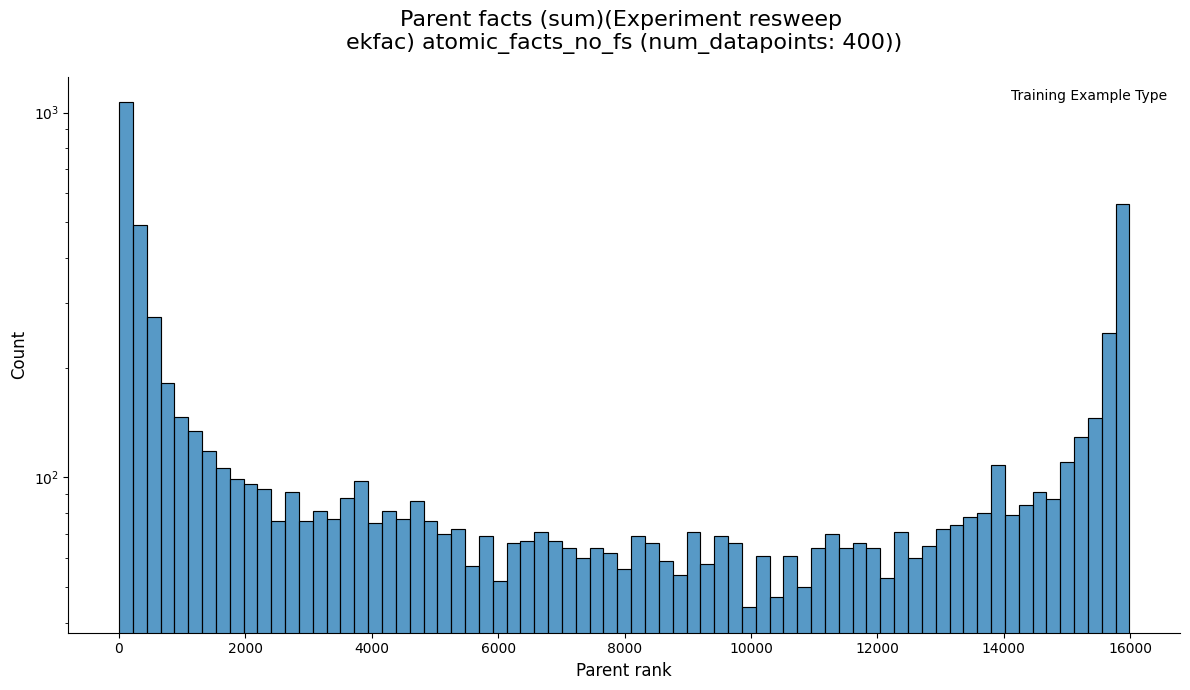

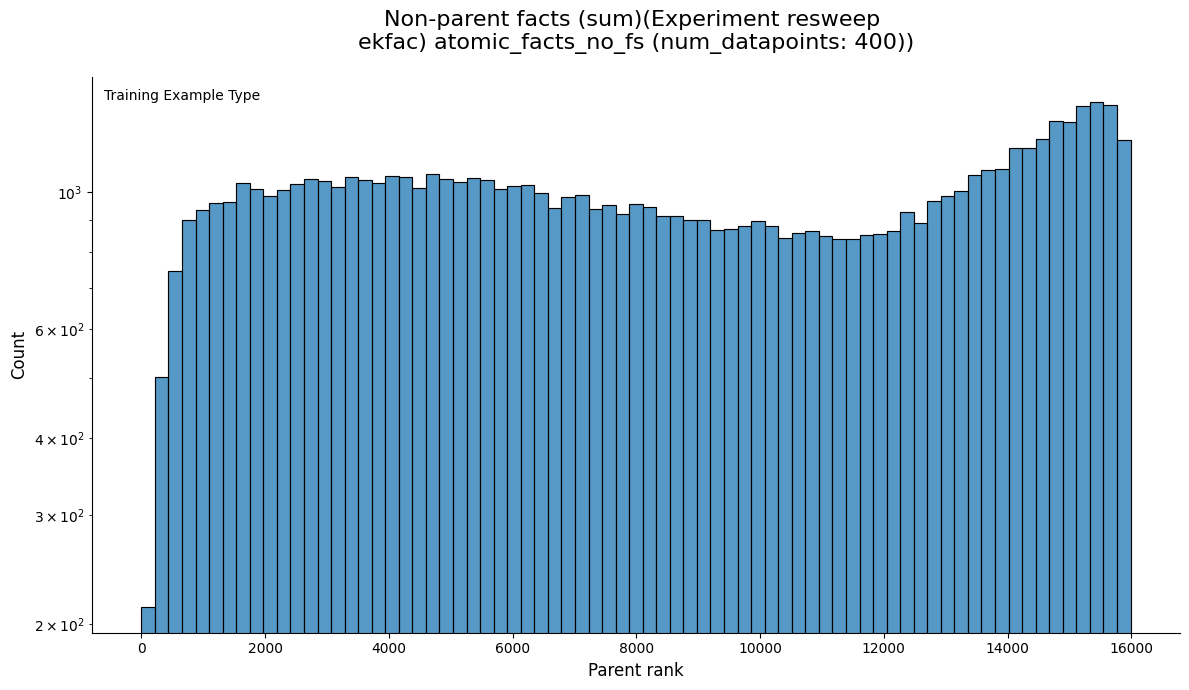

In [53]:
PARENT_ANALYSIS_DIR = Path("./analysis/figures/") / (datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + "influence_histograms")
print(f"PARENT_ANALYSIS_DIR: {PARENT_ANALYSIS_DIR}")
# Part 2: Iddterate over the loaded data and plot
for (all_modules_influence_scores_by_document, train_dataset_by_document, experiment_name_parent, 
     bin_width, test_dataset, probabilities, tokenizer) in zip(
        all_modules_influence_scores_by_document_list,
        train_dataset_by_document_list,
        experiment_name_parent_list,
        bin_width_list,
        test_dataset_list,
        probabilities_list,
        tokenizer_list
    ):
    
    for reduction_for_plots in ["sum"]:
        for lower_bound_on_query_prob in [None]:                

            reduced_scores_by_document = reduce_scores(all_modules_influence_scores_by_document, reduction_for_plots)
            
            analysis_dir = PARENT_ANALYSIS_DIR / (experiment_name_parent).replace("\n", "_")
            analysis_dir.mkdir(parents=True, exist_ok=True)

            print(f"Wrote out top performing documents to {analysis_dir}")
            plot_parent_rank_histogram(scores_df=reduced_scores_by_document, train_dataset=train_dataset_by_document, query_dataset=test_dataset, title=f"Parent facts ({reduction_for_plots})({experiment_name_parent})",xlabel="Parent rank", ylabel="Count",bin_width=bin_width,analysis_dir=analysis_dir)
            plot_parent_rank_histogram(scores_df=reduced_scores_by_document, train_dataset=train_dataset_by_document, query_dataset=test_dataset, non_parents_instead_of_parents=True,title=f"Non-parent facts ({reduction_for_plots})({experiment_name_parent})",xlabel="Parent rank", ylabel="Count",bin_width=bin_width, analysis_dir=analysis_dir)
            
            output_pdf_dict_top_docs = output_top_influence_documents_html(tokenizer=tokenizer,scores_df=reduced_scores_by_document, train_dataset=train_dataset_by_document, query_dataset=test_dataset, prob_vector=probabilities, n_queries=10, n_train=20)
            for key, html_page in output_pdf_dict_top_docs.items():
                with open(analysis_dir / f"{key}.html", "w") as f:
                    f.write(html_page)

### Influence Analysis Top Docs

In [57]:
import json
from oocr_influence.cli.train_extractive import TrainingArgs
import time
import wandb
from pydantic import BaseModel
from datasets import load_from_disk
from shared_ml.logging import LogState, load_log_from_disk
import cProfile
import pstats
import io
from pathlib import Path
import line_profiler 
import matplotlib.style as mplstyle
from datetime import datetime
import string
from shared_ml.data import hash_record
import random
# run_ids = [
# "egb2x2qz",
# "sxeqezsn",
# "vtgxgh5u",
# "nbjzydfy",
# "8t0lc4k4",
# "buzibndf",
# "civr8g38",
# "sktmz6xf",

# "jm303kof",
RUN_IDS = [
"uo7zhyu0"
]   

RUN_IDS_WITH_BROKEN_TEST_DATASET = [
"4ujfx60l",
"mplbfiwn",
"mg1jdbxq",
"g3a8bt2c",
"otax56bp",
"9e0u8ayh",
"mzr12zfs",
"d82qykov",
"325mjpbx",
"k46z37p7"
]

TOP_KS = [5,10,50,100]
experiments_to_analyze = [InfluenceAnalysisDatapoint(analysis_path=run_id, name="Experiment resweep",is_per_token=True, old_type_of_datapoint=run_id in RUN_IDS_WITH_BROKEN_TEST_DATASET) for run_id in RUN_IDS]


from datetime import datetime

experiment_name_parent = f"Averaging across all queries, see the top docs"
prob_vectors_parent = []
original_experiment_logs = []
experiment_analysis_paths = [experiment.analysis_path for experiment in experiments_to_analyze] 
scores_df_list = []
experiment_logs = paths_or_wandb_to_logs(experiment_analysis_paths)
PROFILE = False
SCORE_REDUCTION = "sum"
for experiment, log, path_or_wandb in zip(experiments_to_analyze,experiment_logs, experiment_analysis_paths):
    influence_experiment_log = log
    args = influence_experiment_log.args
    
    args = InfluenceArgs.model_validate(args)
    experiment_output_dir = Path(args.target_experiment_dir)
    print(f"{experiment_output_dir=}")

    _, train_dataset, test_datasets, tokenizer , experiment_log = load_experiment_checkpoint(experiment_output_dir=experiment_output_dir, checkpoint_name="checkpoint_final", load_model=False, load_tokenizer=True)
    assert train_dataset is not None
    assert test_datasets is not None
    assert experiment_log is not None
    assert tokenizer is not None
    
    original_experiment_logs.append(experiment_log)

    if path_or_wandb in RUN_IDS_WITH_BROKEN_TEST_DATASET:
        assert args.query_dataset_split_name is not None

        test_dataset = load_from_disk(Path(f"/h/319/max/malign-influence/outputs/2025_06_02_18-30-01_9capJ_first_time_generating_synthetic_ideas5_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1/eval_datasets/{args.query_dataset_split_name}/eval_dataset"))
    elif args.query_dataset_path is not None:
        test_dataset = load_from_disk(args.query_dataset_path) 
    elif args.query_dataset_split_name is not None:
        test_dataset = test_datasets[args.query_dataset_split_name].dataset # type: ignore
    else:
        raise ValueError("query_dataset_path or query_dataset_split_name should be provided")
    
    if "id" not in train_dataset[0]["packed_documents"][0].keys():
        train_dataset = train_dataset.map(lambda x,idx: {"packed_documents":[ p | {"id": hash_record(p,None)} for p in x["packed_documents"]]}, with_indices=True)
    
    if "id" not in test_dataset.column_names:
        test_dataset = test_dataset.map(lambda x: {"id": hash_record(x,None)})

    
    assert isinstance(train_dataset, Dataset)
    assert isinstance(test_dataset, Dataset)
        
    if "id" not in train_dataset.column_names:
        train_dataset = train_dataset.map(lambda x: {"id": (str(random.random()),None)})
    
    experiment_args = experiment_log.args
    if experiment.old_type_of_datapoint:
        experiment_args = {k:v for k,v in experiment_args.items() if k in TrainingArgs.model_json_schema()["properties"]}
    

    experiment_args = TrainingArgs.model_validate(experiment_args)
    
    num_datapoints = experiment_args.synth_types_per_fact * experiment_args.synth_ideas_per_type * experiment_args.synth_docs_per_idea

    assert args.query_dataset_split_name is not None, "query_dataset_split_name should be provided"
    probabilities = experiment_log.history[-1]["eval_results"][args.query_dataset_split_name]["prob_vector"]
    prob_vectors_parent.append(probabilities)

    t_2_5 = time.time()
    scores_df = load_influence_scores(experiment_output_dir=log.experiment_output_dir, query_dataset=test_dataset, train_dataset=train_dataset)
    scores_df, train_dataset = split_dataset_and_scores_by_document(scores=scores_df, packed_train_ds=train_dataset)
    scores_df = reduce_scores(scores_df, SCORE_REDUCTION)
    scores_df = add_types_to_influence_scores(influence_scores_df=scores_df, train_dataset=train_dataset, test_dataset=test_dataset)
    t3 = time.time()

    scores_df_list.append(scores_df)


    bin_width = max(1, int(len(train_dataset) / 40)) # type: ignore

    t4 = time.time()

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:119: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:123: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/h/319/max/malign-influence-sweep/outputs/2025_06_13_01-10-22_SWEEP_5cfd_saving_every_epoch_train_extractive/2025_06_13_01-10-44_y3jw9_2025_06_13_01-10-22_SWEEP_5cfd_saving_every_epoch_train_extractive_index_0_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_1_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


159850it [00:23, 6876.86it/s]


PARENT_ANALYSIS_DIR: analysis/figures/2025_06_13_17_08_16_Fdd_top_docs


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:119: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:123: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


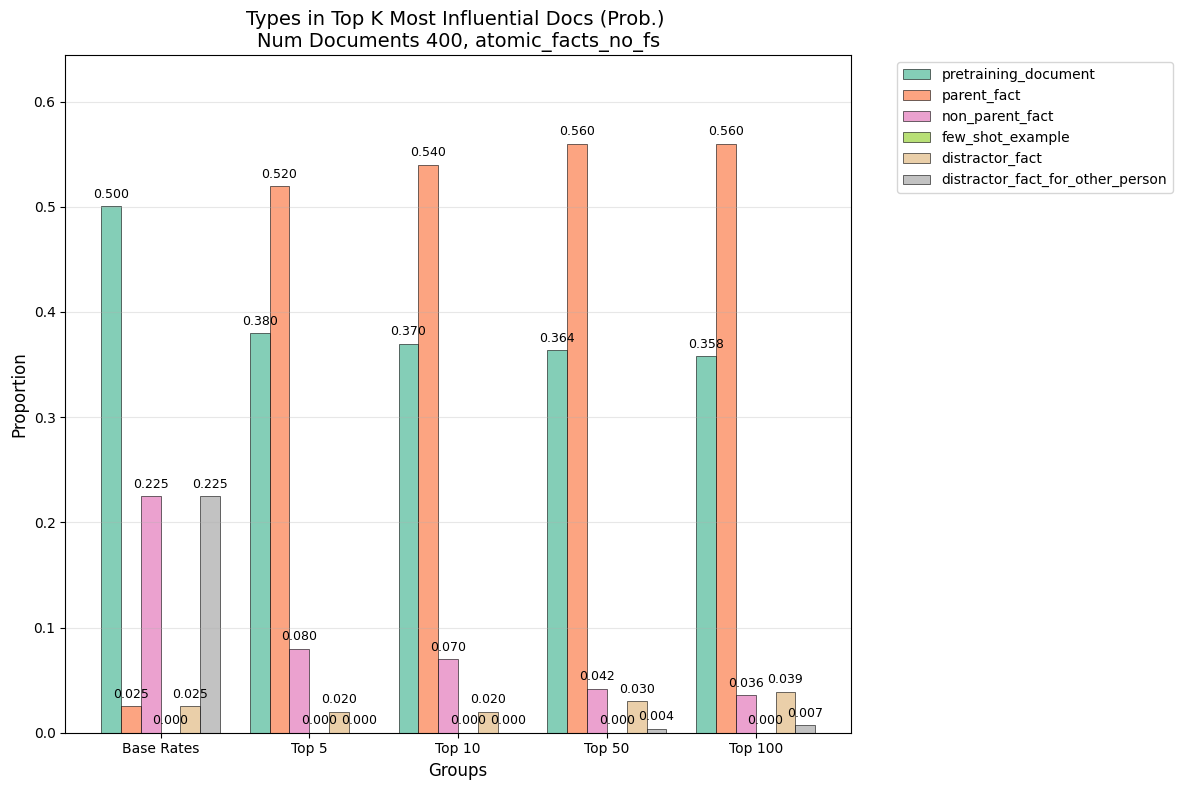

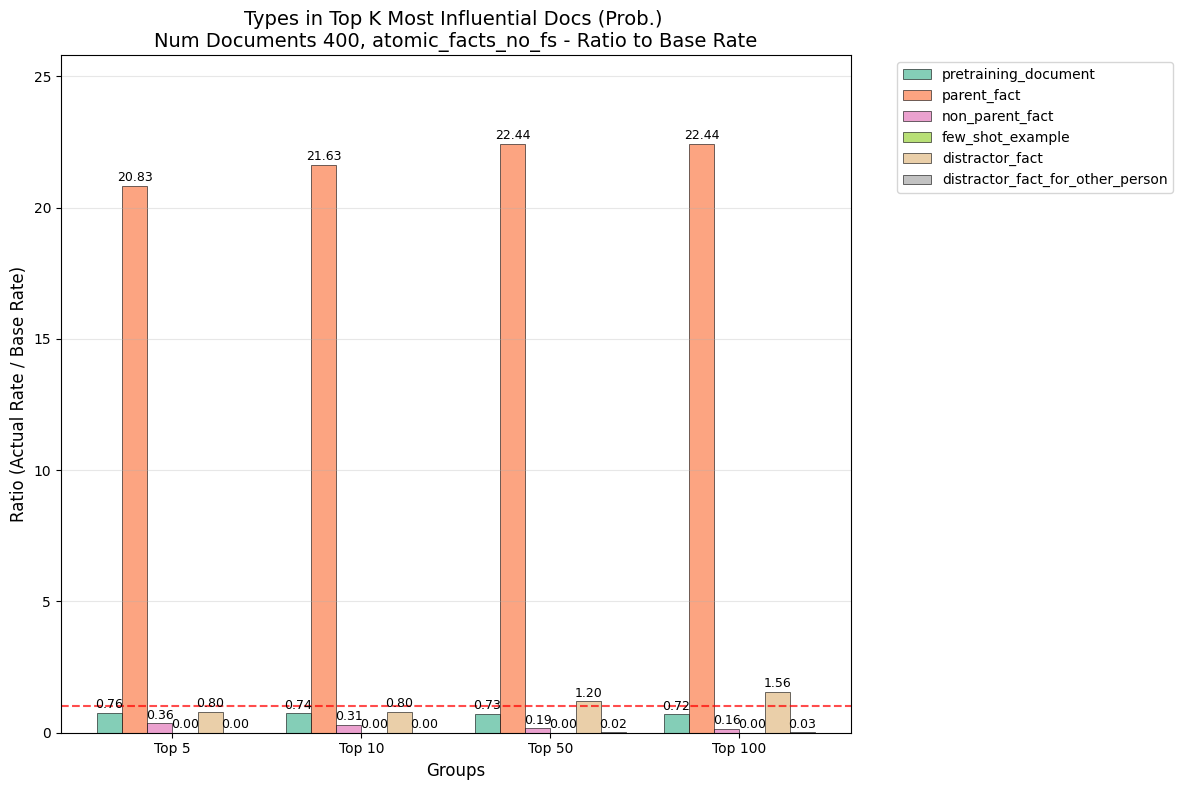

In [59]:
from shared_ml.logging import LogState
from typing import Callable
from datasets import concatenate_datasets

from dataclasses import dataclass
from oocr_influence.cli.run_influence import InfluenceArgs
from oocr_influence.cli.train_extractive import TrainingArgs
import random
import string

PARENT_ANALYSIS_DIR = Path("./analysis/figures/") / (datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + "_" + "".join(random.choices(string.ascii_letters,k=3)) + "_top_docs")
print(f"PARENT_ANALYSIS_DIR: {PARENT_ANALYSIS_DIR}")

@dataclass
class GroupOfExperiments:
    name: str
    experiment_filter: Callable[[InfluenceArgs, TrainingArgs | None], bool]


def filter_number_of_documents(num_docs: int) -> Callable[[InfluenceArgs, TrainingArgs | None], bool]:

    def filter(args: InfluenceArgs, training_args: TrainingArgs) -> bool:

        num_docs_in_training_args =  training_args.synth_types_per_fact * training_args.synth_ideas_per_type * training_args.synth_docs_per_idea
        return num_docs_in_training_args == num_docs
    return filter

groups = []

groups += [GroupOfExperiments(name=f"Num Documents {train_arg.synth_types_per_fact * train_arg.synth_ideas_per_type * train_arg.synth_docs_per_idea}, {arg.query_dataset_split_name}", experiment_filter= lambda x,y,if_arg=arg,t_arg=train_arg: (if_arg.query_dataset_split_name == x.query_dataset_split_name) and (train_arg.synth_ideas_per_type == y.synth_ideas_per_type)) for arg,train_arg in sorted([(InfluenceArgs.model_validate(log.args), TrainingArgs.model_validate(og_log.args)) for log, og_log in zip(experiment_logs, original_experiment_logs)], key=lambda x: x[1].synth_ideas_per_type)]

for group in groups:
    for lower_bound_on_query_prob in [None]:

        experiment_mask = [group.experiment_filter(InfluenceArgs.model_validate(log.args), TrainingArgs.model_validate(original_log.args)) for log, original_log in zip(experiment_logs, original_experiment_logs)]
        prob_vectors = [probabilities for probabilities, mask in zip(prob_vectors_parent, experiment_mask) if mask]
        scores_dfs = [scores_df for scores_df, mask in zip(scores_df_list, experiment_mask) if mask]

        experiment_name_parent = group.name

        if not any(experiment_mask):
            print(f"No test datasets found for {group.name}")
            continue


        analysis_dir = PARENT_ANALYSIS_DIR / experiment_name_parent
        analysis_dir.mkdir(parents=True, exist_ok=True)


        plot_proportions_of_types_in_top_k(influence_scores_df=pd.concat(scores_dfs), top_ks=TOP_KS,title= "Types in Top K Most Influential Docs (Prob.) \n" + experiment_name_parent, analysis_dir=analysis_dir, plot_ratio=False)

        plot_proportions_of_types_in_top_k(influence_scores_df=pd.concat(scores_dfs), top_ks=TOP_KS,title= "Types in Top K Most Influential Docs (Prob.) \n" + experiment_name_parent, analysis_dir=analysis_dir, plot_ratio=True)

In [60]:
original_experiment_logs = []
PROFILE = False
for experiment, log in zip(experiments_to_analyze,experiment_logs):
    influence_experiment_log = log
    args = influence_experiment_log.args
    
    args = InfluenceArgs.model_validate(args)
    experiment_output_dir = Path(args.target_experiment_dir)
    print(f"{experiment_output_dir=}")

    _, train_dataset, test_dataset, tokenizer , experiment_log = load_experiment_checkpoint(experiment_output_dir=experiment_output_dir, checkpoint_name="checkpoint_final", load_model=False, load_tokenizer=True)

    original_experiment_logs.append(experiment_log)

/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_7f5_first_time_generating_synthetic_ideas1_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_7f5_first_time_generating_synthetic_ideas1_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-25-18_2c7_first_time_generating_synthetic_ideas10_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-25-18_2c7_first_time_generating_synthetic_ideas10_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-25-18_baf_first_time_generating_synthetic_ideas20_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-52-47_c8f_first_time_generating_synthetic_ideas40_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-52-47_c8f_first_time_generating_synthetic_ideas40_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_c0d_first_time_generating_synthetic_ideas5_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:113: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:117: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


experiment_output_dir=PosixPath('/mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_c0d_first_time_generating_synthetic_ideas5_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1')


## Analysing High Log Probability Queries

In [6]:
RUN_IDS = [
"egb2x2qz",
"sxeqezsn",
"vtgxgh5u",
"nbjzydfy",
"8t0lc4k4",
"buzibndf",
"civr8g38",
"sktmz6xf",
"jm303kof",
]
experiment_logs = paths_or_wandb_to_logs(RUN_IDS)

influence_args = [InfluenceArgs.model_validate(log.args) for log in experiment_logs]

original_experiment_logs = [load_experiment_checkpoint(experiment_output_dir=Path(args.target_experiment_dir), checkpoint_name="checkpoint_final", load_model=False, load_tokenizer=True)[-1] for args in influence_args]
original_experiment_args = [TrainingArgs.model_validate(log.args) for log in original_experiment_logs]


/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:114: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. lambda_max_examples is set to 500
  warnings.warn(
/h/319/max/malign-influence/src/oocr_influence/cli/run_influence.py:118: UserWarning: covariance_max_examples and lambda_max_examples should be None if covariance_and_lambda_max_examples is set. covariance_max_examples is set to 500
  warnings.warn(


In [185]:
def compare_args_objects(args_list, object_name="args", exclude_keys=[]):
    """
    Compare argument objects and return only keys where there are differences,
    along with the set of different values for those keys.
    
    Args:
        args_list: List of argument objects (like InfluenceArgs or TrainingArgs)
        object_name: Name for the objects being compared (for display purposes)
    
    Returns:
        dict: Dictionary with keys that have differences and their unique values
    """
    if not args_list:
        return {}
    
    # Convert all args to dictionaries
    args_dicts = [args.model_dump() if hasattr(args, 'model_dump') else vars(args) for args in args_list]
    
    # Get all possible keys
    all_keys = set()
    for args_dict in args_dicts:
        all_keys.update(args_dict.keys())
    
    # Find keys with differences
    differing_keys = {}
    
    for key in all_keys:
        if key in exclude_keys:
            continue
        values = []
        for args_dict in args_dicts:
            value = args_dict.get(key, None)
            # Convert non-hashable types to strings for comparison
            if isinstance(value, (list, dict)):
                value = str(value)
            elif isinstance(value, Path):
                value = str(value)
            values.append(value)
        
        # Check if there are differences
        unique_values = set(values)
        if len(unique_values) > 1:
            differing_keys[key] = unique_values
    
    return differing_keys

def print_differences(differing_keys, object_name="args"):
    """
    Pretty print the differences found in argument objects.
    """
    if not differing_keys:
        print(f"No differences found in {object_name}")
        return
    
    print(f"\nDifferences found in {object_name}:")
    print("=" * 50)
    
    for key, values in differing_keys.items():
        print(f"\n{key}:")
        for value in sorted(values, key=str):
            print(f"  - {value}")

# Compare influence_args
influence_differences = compare_args_objects(influence_args, "influence_args")
print_differences(influence_differences, "influence_args")

# influence_difference_per_module_false = compare_args_objects([args for args in influence_args if args.compute_per_module_scores == False], "influence_args_per_module_false", exclude_keys=["experiment_name","output_dir"])
# print_differences(influence_difference_per_module_false, "influence_args_per_module_false")

# influence_difference_per_module_false_and_compute_per_module_scores_false = compare_args_objects([args for args in influence_args if args.compute_per_module_scores == True], "influence_args_per_module_true", exclude_keys=["experiment_name","output_dir"])
# print_differences(influence_difference_per_module_false_and_compute_per_module_scores_false, "influence_args_per_module_true")
# Compare original_experiment_args  
training_differences = compare_args_objects(original_experiment_args, "original_experiment_args")
print_differences(training_differences, "original_experiment_args")



Differences found in influence_args:

target_experiment_dir:
  - /mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_7f5_first_time_generating_synthetic_ideas1_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1
  - /mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-09-55_c0d_first_time_generating_synthetic_ideas5_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1
  - /mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-25-18_2c7_first_time_generating_synthetic_ideas10_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1
  - /mfs1/u/max/malign-influence-sweep/outputs/2025_05_16_03-25-18_baf_first_time_generating_synthetic_ideas20_epochs_synthetic_docs_hop_pretraining_dataset_num_facts_10_num_epochs_5_lr_0.0001_pretrain_dset_size_8000_repeats_trn_1
  - /mfs1/u/max/

In [79]:
from dataclasses import dataclass
from shared_ml.utils import cache_function_outputs

@dataclass
class HighLogProbabilityDatapoint:
    path: Path
    checkpoint_name: str
    influence_analysis_path: Path | None = None
    experiment_name: str = ""
    test_set_name: str = "inferred_facts"
    
    num_outputs_to_visualize: int = 20
    
    num_beams: int = 12
    num_return_sequences: int = 9
    max_new_tokens: int = 2
    num_inputs: int = 10

from oocr_influence.cli.train_extractive import TrainingArgs
experiments_to_analyze = [
    HighLogProbabilityDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_05_07_22-09-38_a11_first_time_generating_synthetic_synthetic_docs_hop_num_facts_1_num_epochs_15_lr_1e-05/"), checkpoint_name="checkpoint_final",experiment_name="Olmo  after pretraining on docs",test_set_name="inferred_facts_second_hop"),    
    HighLogProbabilityDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_05_07_22-09-38_a11_first_time_generating_synthetic_synthetic_docs_hop_num_facts_1_num_epochs_15_lr_1e-05/"), checkpoint_name="checkpoint_final",experiment_name="Olmo  after pretraining on docs",test_set_name="inferred_facts_first_hop"),    
    HighLogProbabilityDatapoint(path=Path("/mfs1/u/max/oocr-influence/outputs/2025_05_07_22-09-38_a11_first_time_generating_synthetic_synthetic_docs_hop_num_facts_1_num_epochs_15_lr_1e-05/"), checkpoint_name="checkpoint_final",experiment_name="Olmo  after pretraining on docs",test_set_name="atomic_facts"),   
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert torch.cuda.is_available()
RUN_IDS = [
    # ("3urxrbpg", "olmo 1 working"),
    # ("y0ssjv88", "olmo 2 not work"),
    # ("iyqvvoeo", "olmo 1 Kinda Work"),
]

for run_id, run_name in RUN_IDS:
    experiment_args, output_dir = run_id_to_training_args(run_id,args_clss=TrainingArgs)
    experiments_to_analyze += [HighLogProbabilityDatapoint(path=Path(output_dir), checkpoint_name="checkpoint_final",experiment_name=run_name)]

    
for experiment in experiments_to_analyze:
    log_state =  LogState.model_validate_json(Path(experiment.path / "experiment_log.json").read_text())
    args = {k:v for k,v in log_state.args.items() if k in TrainingArgs.model_json_schema()["properties"]} # type: ignore
    args = TrainingArgs.model_validate(args)
    
    _, _, test_dataset, tokenizer, log = load_experiment_checkpoint(experiment_output_dir=experiment.path, checkpoint_name=experiment.checkpoint_name, load_model=False, load_tokenizer=True)
    test_dataset = test_dataset[experiment.test_set_name]
    model_inputs = test_dataset["input_ids"][:experiment.num_outputs_to_visualize]
    model_labels = test_dataset["labels"][:experiment.num_outputs_to_visualize]

    # Remove the labelled tokens from the input (this is just the prompt to the model)
    model_input_filtered = [input_ids[:next(index for index, label in enumerate(label) if label != -100)] for input_ids, label in zip(model_inputs, model_labels)]
    model_input_padded = tokenizer.pad({"input_ids": model_input_filtered}, padding_side="left",return_tensors="pt").to(device)
 
    outputs, transition_scores = get_model_outputs_beam_search(input_ids=model_input_padded["input_ids"], attention_mask=model_input_padded["attention_mask"], tokenizer=tokenizer,experiment_path=experiment.path, checkpoint_name=experiment.checkpoint_name, max_new_tokens=experiment.max_new_tokens, num_beams=experiment.num_beams, num_return_sequences=experiment.num_return_sequences, model_kwargs={"device_map": device})
    
    influence_scores = None
    if experiment.influence_analysis_path is not None:
        _, influence_scores = load_pairwise_scores_with_all_modules(experiment.influence_analysis_path)
    
    print(f"Experiment: {experiment.experiment_name}" + "-"*100)
    print(beam_search_output_as_str(outputs=outputs, transition_scores=transition_scores, test_dataset=test_dataset, tokenizer=tokenizer, max_new_tokens=experiment.max_new_tokens, num_return_sequences=experiment.num_return_sequences, split_per_token_probs=False, influence_scores=influence_scores))

    most_likely_tokens, most_likely_probs = get_next_tokens_and_probs(experiment_path=experiment.path, checkpoint_name=experiment.checkpoint_name, input_ids=model_input_padded["input_ids"], attention_mask=model_input_padded["attention_mask"], tokenizer=tokenizer, model_kwargs={"device_map": device},dont_cache_outputs=True)
    tokens_str = ""
    for tokens, probs in zip(most_likely_tokens, most_likely_probs):
        tokens_sorted, probs_sorted = zip(*sorted(zip(tokens, probs), key=lambda x: x[1], reverse=True))
        for token, prob in zip(tokens_sorted, probs_sorted):
            tokens_str  += tokenizer.decode(token) + " " + f"{prob:.4f}"
    print(tokens_str)


AssertionError: 

In [24]:
%%snakeviz
load_pairwise_scores_with_all_modules(Path('outputs/2025_05_22_06-46-03_SWEEP_40a_inf_ablation_covariance_lambda_size_run_influence/2025_05_22_06-48-12_gh6_run_influence_ekfac_2025_05_22_06-46-03_SWEEP_40a_inf_ablation_covariance_lambda_size_run_influence_index_3_checkpoint_checkpoint_final_query_gradient_rank_64'))

Time to load_pairwise_scores: 0.4275083541870117, Time to load all modules 258.8050584793091, Time to cast: 12.207443714141846
 
*** Profile stats marshalled to file '/tmp/tmpznda7z1m'.
Embedding SnakeViz in this document...
<function display at 0x7fbd8e57d760>
